## Importing Libraries

In [2]:
### Run this cell to install surprise library that we will use in exercise 3
# ! pip install scikit-surprise

In [1]:
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import math
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Exercise 2
##### In this task, matrix factorization has been implemented using Stochastic Gradient Descent.


### Utility Functions

In [17]:
def read_data():
    movieLdf = pd.read_csv("u.data", delimiter="\t", header=None)
    movieLdf = movieLdf.drop(movieLdf.columns[3], axis=1)
    return movieLdf

In [18]:
def lossFn(data, p, q, lamda):
    loss = 0
    for x in data:
        a = (x[2]-predict(p,q,x[0]-1,x[1]-1))*(x[2]-predict(p,q,x[0]-1,x[1]-1))
        b = lamda * (np.dot(p[x[0]-1].T, p[x[0]-1]) + np.dot(q[x[1]-1].T, q[x[1]-1]))
        loss = loss + ( a + b )
    return loss

In [19]:
def predict(p, q, user, item):
    return np.dot(p[user].T, q[item])

##### Following function has been created for Stochastic gradient descent algorithm (Algorithm LearnLatentFactors) as described on slide 29:

In [20]:
def trainMF(data, valid, nUsers, nItems, learnR, lamda, factors, epochs, eps):
    p = np.random.normal(size=((nUsers, factors)))
    q = np.random.normal(size=((nItems, factors)))
    
    trainRMSE=[]
    validRMSE=[]
    for i in range(epochs):
        np.random.shuffle(data)
        prevFnV = lossFn(data, p, q, lamda)
        for x in data:
            l = x[2] - predict(p, q, x[0]-1, x[1]-1)

            p[x[0]-1] = p[x[0]-1] + learnR * (l*q[x[1]-1] - lamda*p[x[0]-1])
            q[x[1]-1] = q[x[0]-1] + learnR * (l*p[x[0]-1] - lamda*q[x[1]-1])
            
        trainRMSE.append(np.sqrt(np.mean(np.square(data[:,2] -\
                        [predict(p, q, x[0]-1, x[1]-1) for x in data]))))
        
        if valid is not None:
            validRMSE.append(np.sqrt(np.mean(np.square(valid[:,2] -\
                            [predict(p, q, x[0]-1, x[1]-1) for x in valid]))))
        
        nextFnV = lossFn(data, p, q, lamda)
        
        if(np.abs(prevFnV-nextFnV) < eps):
            break;
            
    return p, q, trainRMSE, validRMSE

##### The following function is used for K-fold split:

In [21]:
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = np.copy(dataset)
    fold_size = math.ceil(len(dataset) / folds)
    for i in range(folds):
        if (i < folds-1):
            dataset_split.append(dataset_copy[i*fold_size:(i+1)*fold_size])
        else:
            dataset_split.append(dataset_copy[i*fold_size:len(dataset)])
    return dataset_split

##### Function to perform training using  LearnLatentFactors Algorithm

In [22]:
def kFoldCV(data, factors, learnR, lamda, k, epochs, eps=0.001):
    np.random.shuffle(data)
    folds = cross_validation_split(data, k)
    
    listCVE = []
    for i in range(len(folds)):
        train = np.vstack([x for x in folds if x is not folds[i]])
        valid = folds[i]

        _, _, listTrainRMSE, listValidRMSE = trainMF(\
            data, valid, 943, 1682, learnR, lamda, factors, epochs, eps)
            
        listCVE.append(listValidRMSE[-1])
    
    return np.mean(listCVE)

### Main Function

In [24]:
movieLdf = read_data() ### read data

In [25]:
### Split the data into train and test set. The train set is further divided into train and validate set in kFoldCV function above 

trainData = movieLdf.values[0:int(0.9*100000)] 
testData = movieLdf.values[int(0.9*100000):]

### Hyper paramters optimization to get best paramters that give use minimum rmse on validation set

In [26]:
n_factors = [20, 40]
listAlpha = [0.005, 0.003]
listLamda = [0.01, 0.1]

listRMSE = np.zeros((3, 3, 3))

for i , factors in enumerate(n_factors):
    for j, alpha in enumerate(listAlpha):
        for k, lamda in enumerate(listLamda):
            print("n_Factors=", factors, " alpha=", alpha, " lambda=", lamda)
            listRMSE[i, j, k] = kFoldCV(trainData, factors, alpha, lamda, 3, 10) #Using only train data which will be further divided into train and validate set inside the kFoldCV function
            print("RMSE on validation set = ", listRMSE[i, j, k])

n_Factors= 20  alpha= 0.005  lambda= 0.01
RMSE on validation set =  1.0999056337461874
n_Factors= 20  alpha= 0.005  lambda= 0.1
RMSE on validation set =  1.069648250590203
n_Factors= 20  alpha= 0.003  lambda= 0.01
RMSE on validation set =  1.0661329946623537
n_Factors= 20  alpha= 0.003  lambda= 0.1
RMSE on validation set =  1.046282108508331
n_Factors= 40  alpha= 0.005  lambda= 0.01
RMSE on validation set =  1.10578560665887
n_Factors= 40  alpha= 0.005  lambda= 0.1
RMSE on validation set =  1.0865546917210298
n_Factors= 40  alpha= 0.003  lambda= 0.01
RMSE on validation set =  1.0721369953113398
n_Factors= 40  alpha= 0.003  lambda= 0.1
RMSE on validation set =  1.065423065430813


### Above results shows that we got minimum RMSE on validation set with n_Factor=20, alpha= 0.003 and lambda= 0.1. So we will use these hyper paramters.

In [27]:
p, q, listTrainRMSE, listTestRMSE = trainMF(trainData, testData, 943, 1682, 0.003, 0.1, 20, 50, 0.01) 

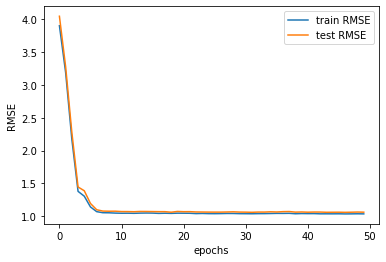

In [28]:
plt.plot(listTrainRMSE, label="train RMSE")
plt.plot(listTestRMSE, label="test RMSE")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

#### RMSE on test set

In [78]:
listTestRMSE[0] ###Rmse on test set

2.937676496510638

<hr style="border:2px solid gray"> </hr>

# Exercise 3

## Library 1 Surprise:

Surprise is a Python scikit building and analyzing recommender systems.

 Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
Provide tools to evaluate, analyse and compare the algorithms performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.
The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.

We used SVD to solve the problem

Singular value decomposition takes a rectangular matrix of gene expression data (defined as A, where A is a n x p matrix) in which the n rows represents the genes, and the p columns represents the experimental conditions. The SVD theorem states:

A(nxp)= U(nxn) * S(nxp) * V.T(pxp)

Where

U.T*U = I(nxn)

V.T*V = I(px)p  (i.e. U and V are orthogonal)

 

Where the columns of U are the left singular vectors (gene coefficient vectors); S (the same dimensions as A) has singular values and is diagonal (mode amplitudes); and V.T has rows that are the right singular vectors (expression level vectors). The SVD represents an expansion of the original data in a coordinate system where the covariance matrix is diagonal.

 

Calculating the SVD consists of finding the eigenvalues and eigenvectors of A*A.T and A.T*A. The eigenvectors of A.T*A make up the columns of V , the eigenvectors of A*A.T  make up the columns of U. Also, the singular values in S are square roots of eigenvalues from A*A.T or A.T*A.  The singular values are the diagonal entries of the S matrix and are arranged in descending order. The singular values are always real numbers. If the matrix A is a real matrix, then U and V are also real.

 

## Loading and splitting the dataset

In [3]:
# Use movielens-100K
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\fahad/.surprise_data/ml-100k


## Hyper parameter optimization

In [5]:
# ----- SVD ----- #

param_grid = {'n_factors': [120, 140, 160], 'n_epochs': [30], 'lr_all': [0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)

0.9228534951706099
{'n_factors': 120, 'n_epochs': 30, 'lr_all': 0.008, 'reg_all': 0.1}
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9209  0.9228  0.9278  0.9238  0.0029  
Fit time          7.90    7.88    7.88    7.89    0.01    
Test time         0.36    0.27    0.27    0.30    0.04    


{'test_rmse': array([0.92090295, 0.92281803, 0.92775973]),
 'fit_time': (7.896497488021851, 7.8844685554504395, 7.881486654281616),
 'test_time': (0.364790678024292, 0.27086424827575684, 0.2698338031768799)}

### Using the optimal hyper paramters with SVD for matrix factorization 

In [7]:
# Use the new parameters with the train data and fit the model
algo = SVD(n_factors=120, n_epochs=30, lr_all=0.008, reg_all=0.1)
algo.fit(trainset)

#Now do the prediction on test set
test_pred = algo.test(testset)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 0.9103


0.9102689311896246

### Library 2 Scikit Learn

### Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

The objective function is:

0.5 * ||X - WH||_Fro^2
+ alpha * l1_ratio * ||vec(W)||_1
+ alpha * l1_ratio * ||vec(H)||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||W||_Fro^2
+ 0.5 * alpha * (1 - l1_ratio) * ||H||_Fro^2
Where:

||A||_Fro^2 = \sum_{i,j} A_{ij}^2 (Frobenius norm)
||vec(A)||_1 = \sum_{i,j} abs(A_{ij}) (Elementwise L1 norm)
For multiplicative-update (‘mu’) solver, the Frobenius norm (0.5 * ||X - WH||_Fro^2) can be changed into another beta-divergence loss, by changing the beta_loss parameter.

The objective function is minimized with an alternating minimization of W and H.

It uses Coordinate Descent (CD).

### Utility Functions

In [64]:
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = np.copy(dataset)
    fold_size = math.ceil(len(dataset) / folds)
    for i in range(folds):
        if (i < folds-1):
            dataset_split.append(dataset_copy[i*fold_size:(i+1)*fold_size])
        else:
            dataset_split.append(dataset_copy[i*fold_size:len(dataset)])
    return dataset_split

In [65]:
def kFoldCV1(R, data, factors, lamda, k):
    np.random.shuffle(data)
    folds = cross_validation_split(data, k)
    
    listCVE = []
    for i in range(len(folds)):
        train = np.vstack([x for x in folds if x is not folds[i]])
        valid = folds[i]
        
        RCopy = R.copy()
        for x in valid:
            RCopy[x[0]-1, x[1]-1] = 0

        model = NMF(n_components=factors, init='random', alpha=lamda)
        W = model.fit_transform(RCopy)
        H = model.components_
        
        R_pred = np.dot(W, H)
        
        rmse = 0
        for x in valid:
            rmse += (x[2] - R_pred[x[0]-1, x[1]-1])**2
        rmse /= valid.shape[0]
        rmse = np.sqrt(rmse)
            
        listCVE.append(rmse)
    
    return np.mean(listCVE)

### Reading Data

In [66]:
movieLdf = pd.read_csv("u.data", delimiter="\t", header=None)
movieLdf = movieLdf.drop(movieLdf.columns[3], axis=1)

In [67]:
new_df = movieLdf.pivot(index = 0, columns = 1, values = 2).fillna(0).values

### Splitting the dataset

In [68]:
### Split the data into train and test set. The train set is further divided into train and validate set in kFoldCV1 function above 

trn , tst = train_test_split(movieLdf, test_size = 0.3)

In [69]:
for x in tst.values:
    new_df[x[0]-1, x[1]-1] = 0

### Hyper paramter optimization with  3-folds cross validation 

In [70]:

n_factors = [2, 4, 5, 7, 9 , 11, 15, 20, 80, 160]
listLamda = [0.001, 0.1]

listRMSE = np.zeros((10, 2))

print("Validataion RMSE is \n\n")
for i , factors in enumerate(n_factors):
        for j, lamda in enumerate(listLamda):
            print("n_Factors=", factors, " lambda=", lamda)
            listRMSE[i, j] = kFoldCV1(new_df, trn.values, factors, lamda, 3)
            print("RMSE=", listRMSE[i, j])

Validataion RMSE is 


n_Factors= 2  lambda= 0.001
RMSE= 3.168940044834376
n_Factors= 2  lambda= 0.1
RMSE= 3.170897553576435
n_Factors= 4  lambda= 0.001
RMSE= 3.1051451443952733
n_Factors= 4  lambda= 0.1
RMSE= 3.1054734527947514
n_Factors= 5  lambda= 0.001
RMSE= 3.090639067795783
n_Factors= 5  lambda= 0.1
RMSE= 3.0933526522721304
n_Factors= 7  lambda= 0.001
RMSE= 3.0706652153821588
n_Factors= 7  lambda= 0.1
RMSE= 3.075249407530737
n_Factors= 9  lambda= 0.001
RMSE= 3.070228741203023
n_Factors= 9  lambda= 0.1
RMSE= 3.0747962556417403
n_Factors= 11  lambda= 0.001
RMSE= 3.07129432249428
n_Factors= 11  lambda= 0.1
RMSE= 3.077932790032984
n_Factors= 15  lambda= 0.001
RMSE= 3.085845518297336
n_Factors= 15  lambda= 0.1
RMSE= 3.08697013427585
n_Factors= 20  lambda= 0.001
RMSE= 3.10654914748768
n_Factors= 20  lambda= 0.1
RMSE= 3.109057918116239
n_Factors= 80  lambda= 0.001
RMSE= 3.27823543830746
n_Factors= 80  lambda= 0.1
RMSE= 3.27645402958872
n_Factors= 160  lambda= 0.001
RMSE= 3.4124761577735

#### Above results shows that we got minimum RMSE on validation set with n_Factor=9, alpha= 0.001. So we will use these hyper paramters.

In [71]:
model = NMF(n_components=9, init='random', alpha=0.001)
W = model.fit_transform(new_df)
H = model.components_

In [72]:
r = np.dot(W,H)
print("RMSE on test set is")
np.sqrt(np.mean(np.square(tst.values[:,2] -\
                [r[x[0]-1, x[1]-1] for x in tst.values])))

RMSE on test set is


2.763689353496737

#### My naive implementation of matrix factorization give 2.9 Rmse on test set, build in library sci-learn matrix factorization which gives 2.7 Rmse on test set  as compared to sci-learn surprise library which give 0.9 Rmse on test set. This shows that Surprise's SVD is performing best with with RMSE of 0.9. 